<a href="https://colab.research.google.com/github/PerfectMach1ne/uni-ai-ml/blob/main/wyklad7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification problem: prediction of programming language based on code**

Import of necessary libraries and moduls

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import balanced_accuracy_score


Read data from file csv

In [ ]:
df = pd.read_csv('data_nlp.csv', sep=',')
df.head()

,language,proj_id,file_id,file_body
0,JavaScript,10001,100001,// Functions as values of a variable\nvar cube...
1,JavaScript,10001,100002,// Functions as values of a variable\nvar cube...
2,JavaScript,10002,100003,function median(ary) {\n if (ary.length == ...
3,JavaScript,10002,100004,"[\n null,\n 4,\n 3.5,\n 2.1\n]\n"
4,JavaScript,10002,100005,(() => {\n 'use strict';\n\n // median :...


Checking Nan values in data <br>
Deleting rows with Nan values

In [ ]:
df.isna().sum()

language     0
proj_id      0
file_id      0
file_body    4
dtype: int64

In [ ]:
mask=df["file_body"].isna()
df=df[~mask]
df.isna().sum()

language     0
proj_id      0
file_id      0
file_body    0
dtype: int64

Checking if one project is written in one or more programming languages - One project can be written in several programming languages <br>
It was decided to remove columns: proj_id and file_id. We consider a one row as one observation.

In [ ]:
df.groupby(by="proj_id").count().sort_values(by="language", ascending=False)

,language,file_id,file_body
proj_id,,,
17404,41,41,41
19276,19,19,19
10888,15,15,15
11158,14,14,14
11364,14,14,14
...,...,...,...
15238,1,1,1
15237,1,1,1
15236,1,1,1


In [ ]:
df.drop(columns=["proj_id","file_id"], inplace=True)
df.head()

Checking how many of each class observation is stored in the column language <br>
The number of observations is not the same in each class. This fact will be taken into consideration during classification process

In [ ]:
classes=df["language"].value_counts()

data = [go.Bar( x = classes.index, y = classes.values)]
fig = go.Figure(data=data)
fig.update_layout( title_text='Fig 1. Number of observations per each class')
fig.show()

The features were extracted based on the file_body column. <br>
The tokens were defined and the file_body column was vectorized <br>
The plot on Fig 2. shows the frequency of words. Asis x contains index of word and axis y contains frequency (shown on logarytmic scale). Words were sorted in descending order.It can be seen that approximately 1000 tokens have frequency over 100. <br>
It can be observed that only small portion of words constitute the deciding majority which can be seen on another plot (Fig 3.) showing relative cumulated frequency. <br>
It is quite obvious that programming languages can be distinguished by some limited set of key tokens. The goal is to find the optimal number of tokens ensuring both high classification quality and resonable computational time. As a starting point the number of tokens ensuring 0.8 of relative cumulated frequency is taken.

In [ ]:
pattern = '[a-zA-Z_]{2,}|[.:><=!$%#@\-+\\/|&?*]{1,}'
vectorizer=CountVectorizer(token_pattern = pattern)

#macierz ktora zawiera liczbe wystapien kazdego tokena dla kazdej obserwacji
matrix=vectorizer.fit_transform(df["file_body"])
#nazwy tokentow
features=vectorizer.get_feature_names_out()

#stworzenie slownika token:liczba wystapien
dictionary={}
for column, feature in zip(matrix.T, features):
    dictionary[feature]=column.toarray().sum()

word_freq=np.array(list(dictionary.values()))
words=np.array(list(dictionary.keys()))

#posortowanie tokenow wzgledem liczby wystapien
indexes=np.argsort(word_freq)[::-1]
word_freq=word_freq[indexes]
words=words[indexes]

#wykres w skali logarytmicznej
data = [go.Scatter( x = list(range(word_freq.shape[0])), y = np.log(word_freq))]
fig = go.Figure(data=data)
fig.update_layout( title_text='Fig 2. Sorted token log frequency',
                  xaxis = dict(title = 'number of token'), yaxis = dict( title = 'frequency'))
fig.show()


In [ ]:
#wykres bez skali logarytmicznej
data = [go.Scatter( x = list(range(word_freq.shape[0])), y = word_freq)]
fig = go.Figure(data=data)
fig.update_layout( title_text='Fig 2. Sorted token frequency',
                  xaxis = dict(title = 'number of token'), yaxis = dict( title = 'frequency'))
fig.show()

In [ ]:
matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
matrix.shape

(16268, 42284)

In [ ]:
features

array(['!', '!!', '!!!', ..., '||=', '|||', '|||:='], dtype=object)

In [ ]:
len(dictionary)

42284

In [ ]:
words

array(['.', '=', ':', ..., 'static_assertion_',
       'static_assertion_at_line_', 'mdxv'], dtype='<U130')

In [ ]:
word_freq

array([119602,  89662,  41140, ...,      1,      1,      1])

In [ ]:
#obliczenie skumulowanej frekwencji
word_freq_cum=word_freq.cumsum()/word_freq.sum()

data = [go.Scatter( x = list(range(word_freq_cum.shape[0])), y = word_freq_cum)]
fig = go.Figure(data=data)
fig.update_layout( title_text='Fig 3. Relative cumulated frequency',
                  xaxis = dict(title = 'number of n first tokens'), yaxis = dict( title = 'cumulated frequency'))
fig.show()

mask=word_freq_cum<=0.8
number_of_tokens=mask.sum()
print(f'{number_of_tokens} tokens cover 0.8 of relatived cumulated frequency')

1063 tokens cover 0.8 of relatived cumulated frequency


Firslty rought estimation of optimal token number will be conducted. The performance will be checked in the range from 100 to 1200 with the step 200. As the estimator Random Forest was chosen. <br>
In order to make testing more efficient a pipeline object wrapping all the processing steps was created. <br>
The pipeline contains three steps: <br>
- vectorization based on pattern (looking for tokens composed of letters and special characters) and max_features. Convert a collection of text documents to a matrix of token counts <br>
- transformation. The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus. <br>
- classification model (Random Forest) <br>
The fact that we have different number of observation of each class has to be taken into account. Due to this fact stratified split was applied. Stratify parameter will preserve the proportion of target as in original dataset, both in the train and validation datasets. As a quality measure balanced accuracy was utilized in order to take into consideration class imbalance. <br>

As it can be seen the most notable quality gain is ensured by increasing the number of features from 300 to 500. To further analysis 700 features were taken.

In [ ]:
X=df["file_body"]

encoder = LabelEncoder()
y=df["language"]
y= encoder.fit_transform(y)

pattern = '[a-zA-Z_]{2,}|[.:><=!$%#@\-+\\/|&?*]{1,}'
for no_features in range(100,1200,200):
    pipeline = Pipeline([['CountVectorizer', CountVectorizer(max_features = no_features, token_pattern = pattern)],
                     ['TfidfTransformer', TfidfTransformer()],
                     ['RandomForestClassifier',RandomForestClassifier()]
                    ])
    scores = cross_val_score(estimator=pipeline, X=X, y=y, cv=StratifiedKFold(5), scoring='balanced_accuracy')
    print(f'Mean {scores.mean()} no features {no_features}')

Mean 0.8458639765184804 no features 100
Mean 0.8690972286279912 no features 300
Mean 0.876163632614748 no features 500
Mean 0.8836719161953404 no features 700
Mean 0.8834686281624894 no features 900
Mean 0.8847400354330842 no features 1100


In [ ]:
no_features=700
pipeline = Pipeline([['CountVectorizer', CountVectorizer(max_features = no_features, token_pattern = pattern)],
                     ['TfidfTransformer', TfidfTransformer()],
                     ['RandomForestClassifier',RandomForestClassifier()]
                    ])

scores = cross_val_score(estimator=pipeline, X=X, y=y, cv=StratifiedKFold(5),scoring='balanced_accuracy')
print(f'Mean {scores.mean()}')

Mean 0.8829209952942365


Self implemented cross validation was conducted in ordetr to obtain average confusion matrix. <br>
It can be seen where which pair of classes are hardest to distiguish between <br>
Interestingly Mathematica was the language with which other language were mistaken the most often. (for example Haskell, JavaScript and Julia)

Mean 0.8830174081994038


(<Figure size 1500x1500 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

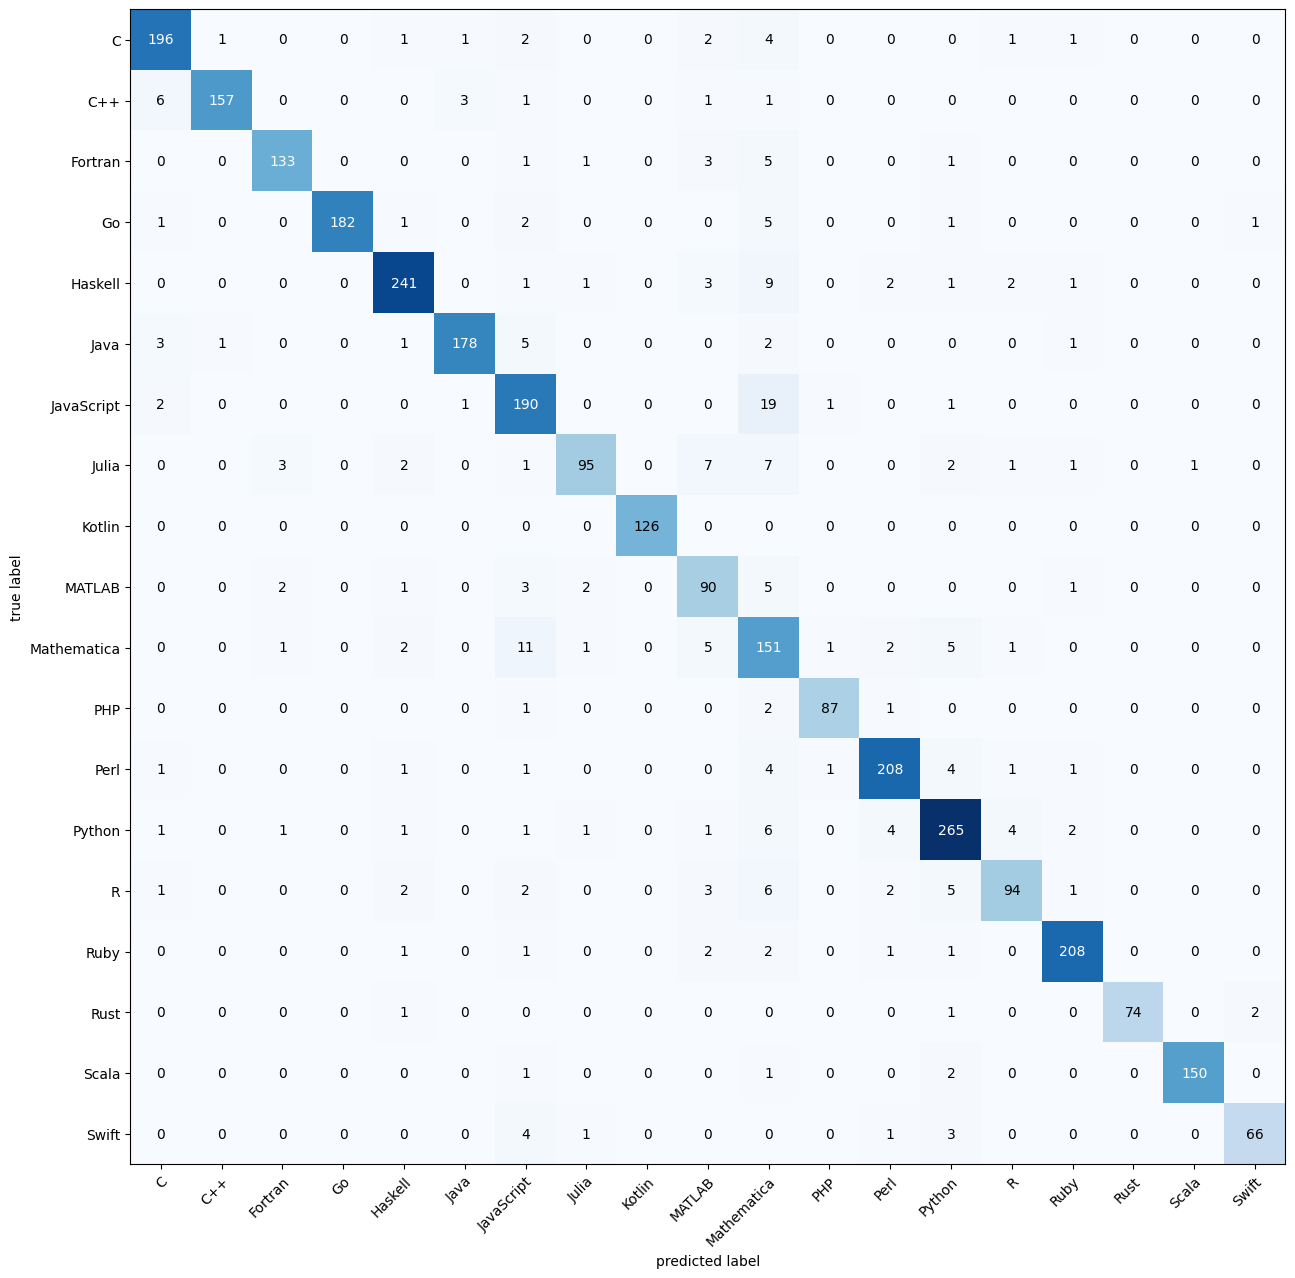

In [ ]:
acc=[]
cmm=[]
fold_number=5
x_train=X.values
for x_train_index, x_valid_index in StratifiedKFold(fold_number).split(x_train,y):
    x_train_k=x_train[x_train_index]
    x_valid_k=x_train[x_valid_index]

    y_train_k=y[x_train_index]
    y_valid_k=y[x_valid_index]

    pipeline.fit(x_train_k, y_train_k)
    y_pred=pipeline.predict(x_valid_k)

    cm = confusion_matrix(y_valid_k, y_pred)
    ac=balanced_accuracy_score(y_valid_k, y_pred)
    acc.append(ac)
    cmm.append(cm)

acc = np.array(acc)
print(f'Mean {acc.mean()}')
cmm=np.array(cmm).mean(axis = 0)

class_names=encoder.classes_
plot_confusion_matrix(cmm,class_names=class_names, figsize=(15, 15))

RandomForestClassifier returns the importance weights of features so based on these weights the chart can be created.  The importance values were sorted in descending order and placed 30 first features from ranking. The most distinguishing features can be observed. For example: dollar most probably allows to distingusih PHP (as every variable starts with $ in PHP), end, def are associated with python etc.

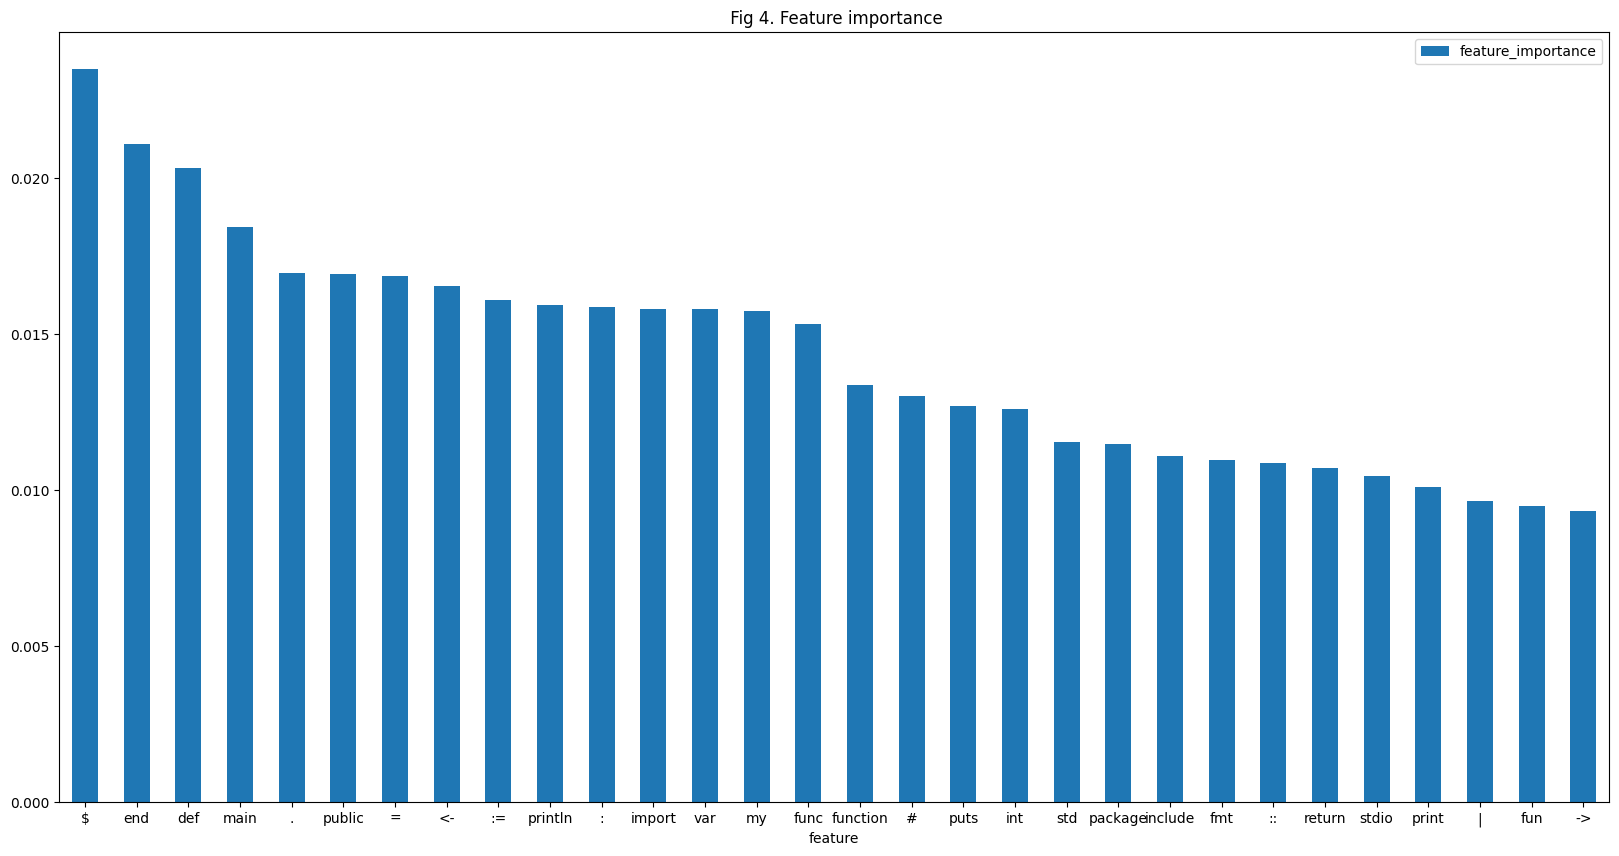

In [ ]:
features_name=pipeline.named_steps['CountVectorizer'].get_feature_names_out()
weights_of_features=pipeline.named_steps['RandomForestClassifier'].feature_importances_

features = pd.DataFrame(data={'feature': features_name, 'feature_importance': weights_of_features})
features.sort_values(by='feature_importance', ascending=False,inplace=True )

ax = features.iloc[0:30, :].plot.bar(x='feature', y='feature_importance', rot=0, title=' Fig 4. Feature importance', figsize=(20,10))

You can test your text containing programming language

In [ ]:
pipeline_test = Pipeline([['CountVectorizer', CountVectorizer(max_features = no_features, token_pattern = pattern)],
                     ['TfidfTransformer', TfidfTransformer()],
                     ['RandomForestClassifier',RandomForestClassifier()]
                    ])
pipeline_test.fit(X, y)

Pipeline(steps=[('CountVectorizer',
                 CountVectorizer(max_features=700,
                                 token_pattern='[a-zA-Z_]{2,}|[.:><=!$%#@\\-+\\/|&?*]{1,}')),
                ('TfidfTransformer', TfidfTransformer()),
                ['RandomForestClassifier', RandomForestClassifier()]])

In [ ]:
def try_your_text(text,pipeline_test, encoder):
    y_pred=pipeline_test.predict(text)
    print(f'Answer {encoder.classes_[y_pred]}')

print('Your text must be a list')
text=['''
def try_your_text(text):
    y_pred=pipeline.predict(text)
    print(f'Answer {encoder.classes_[y_pred]}')
    print('You text must be a list')
    text=[''''''] #copy here your text
    try_your_text(text)'''] #copy here your text

try_your_text(text,pipeline_test, encoder)

You text must be a list
Answer ['Python']


T-SNE method was applied int order to vizualize data in R2 space. Even if we have two compnents it can be observed that some classes are easily separable. For example: C, C++, Fortran, Go, Python, Haskell, Perl.

In [ ]:
pipe_transform = Pipeline(pipeline.steps[:-1])
tsne = TSNE(n_components=2, verbose=1, init='random')
X_train_tsne = tsne.fit_transform(pipe_transform.transform(X))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16268 samples in 0.003s...
[t-SNE] Computed neighbors for 16268 samples in 268.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16268
[t-SNE] Computed conditional probabilities for sample 2000 / 16268
[t-SNE] Computed conditional probabilities for sample 3000 / 16268
[t-SNE] Computed conditional probabilities for sample 4000 / 16268
[t-SNE] Computed conditional probabilities for sample 5000 / 16268
[t-SNE] Computed conditional probabilities for sample 6000 / 16268
[t-SNE] Computed conditional probabilities for sample 7000 / 16268
[t-SNE] Computed conditional probabilities for sample 8000 / 16268
[t-SNE] Computed conditional probabilities for sample 9000 / 16268
[t-SNE] Computed conditional probabilities for sample 10000 / 16268
[t-SNE] Computed conditional probabilities for sample 11000 / 16268
[t-SNE] Computed conditional probabilities for sample 12000 / 16268
[t-SNE] Computed conditional probabilities for s

In [ ]:
xtsne_df = pd.DataFrame(np.concatenate([X_train_tsne, np.expand_dims(y, axis=-1)],axis=-1),
                       columns = ['tsne_1', 'tsne_2', 'class'])

classes=encoder.classes_
clss = {i:c for i, c in enumerate(classes)}
print(clss)

px.scatter(xtsne_df, x='tsne_1', y='tsne_2', color='class', opacity=0.5, width=950, height=700,
           template='plotly_dark', title='Fig 5. TSNE - 2 components')

{0: 'C', 1: 'C++', 2: 'Fortran', 3: 'Go', 4: 'Haskell', 5: 'Java', 6: 'JavaScript', 7: 'Julia', 8: 'Kotlin', 9: 'MATLAB', 10: 'Mathematica', 11: 'PHP', 12: 'Perl', 13: 'Python', 14: 'R', 15: 'Ruby', 16: 'Rust', 17: 'Scala', 18: 'Swift'}


**Classification problem: sentiment analysis**

In [ ]:
import os
import pandas as pd
from pathlib import Path
path_to_file="data_movie.csv"
directory = Path(os.path.dirname(os.path.abspath("__file__")))
comments=pd.read_csv(os.path.join(directory,path_to_file), engine='python',error_bad_lines=False )

Skipping line 38818: unexpected end of data


Dataset exploration

In [ ]:
comments.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
comments['sentiment'].value_counts()

negative    396
positive    373
Name: sentiment, dtype: int64

Encoding classes to numbers. We have binary classification so 0/1

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(comments['sentiment'])

LabelEncoder()

In [ ]:
list(le.classes_)

['negative', 'positive']

In [ ]:
comments['sentiment']=le.transform(comments['sentiment'])

Transformer calculates embeddings for each review.

What is embedding?

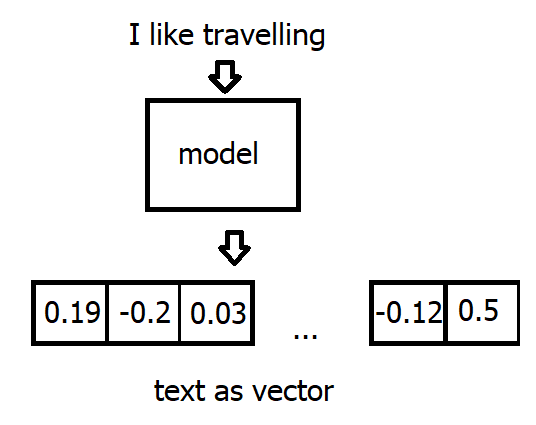

In [ ]:
import os
from pathlib import Path
from sys import _xoptions
from typing import Union

import re
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.metrics as metrics
import xgboost as xgb


import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


class BaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X,y=None):
        return self
    def transform(self, X):
        pass


class CalculateEmbeddings(BaseTransformer):
    """Caluclates embeddings
    """

    def __init__(self, comment_column) -> None:
        """Inits the name of column
        """
        self.comment_column=comment_column


    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Calculates embeddings
        """
        X_=X.copy()
        X_['embedded'] = embed(X[self.comment_column]).numpy().tolist()
        return X_

In [ ]:
from sklearn.pipeline import Pipeline
#calculating embeddings
transformer_embeddings=Pipeline(steps=[("CalculateEmbeddings", CalculateEmbeddings("review"))])
comments_embeddings=transformer_embeddings.fit_transform(comments)

X_embeddings=comments_embeddings["embedded"]
y=comments_embeddings["sentiment"]

#to train_split data and after to have access to comments
indexes=np.array(range(comments_embeddings.shape[0]))

Learning and testing process. Embeddings are the input to model

In [ ]:
from sklearn.model_selection import train_test_split

acc_list=[]
indexes_list=[]
predictions_list=[]

for i in range(10):
    X_train_in, X_test_in, y_train, y_test =  train_test_split(indexes, y.values, test_size = 0.2)

    X_train=X_embeddings[X_train_in]
    X_test=X_embeddings[X_test_in]

    X_train = np.stack(list(X_train), axis = 0)
    X_test = np.stack(list(X_test), axis = 0)

    model = xgb.XGBClassifier(max_depth = 4, colsample_bytree = 0.8, n_estimators = 100)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    acc=metrics.accuracy_score(y_test, prediction)
    acc_list.append(acc)
    indexes_list.append(X_test_in)
    predictions_list.append(prediction)


In [ ]:
acc_list

[0.8311688311688312,
 0.8181818181818182,
 0.8181818181818182,
 0.8441558441558441,
 0.8181818181818182,
 0.8831168831168831,
 0.8376623376623377,
 0.8441558441558441,
 0.8311688311688312,
 0.8311688311688312]

In [ ]:
comments

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
764,I first saw this film when I was about 8 years...,1
765,This film can't make up its mind whether its m...,0
766,"Why, o' WHY! ...did I pick this one up? Well.....",0
767,Only a very small child could overlook the abs...,0


Creating dataframe which contains reviews, true sentiment and prediction sentiment

In [ ]:
test_comments=comments['review'][indexes_list[0]]
test_sentiment_true=comments['sentiment'][indexes_list[0]]
test_sentiment_predictions=predictions_list[0]

In [ ]:
dict_results={"comments":test_comments, "sentiment_true": test_sentiment_true, "sentiment_predictions":test_sentiment_predictions}
results_df=pd.DataFrame(dict_results)

We can check where our model made mistake

In [ ]:
results_df.head(10)

,comments,sentiment_true,sentiment_predictions
616,This is my first Deepa Mehta film. I saw the f...,1,1
378,"It doesn't happen very often, but occasionally...",1,1
28,This movie was so frustrating. Everything seem...,0,0
55,As someone has already mentioned on this board...,0,0
701,I Enjoyed Watching This Well Acted Movie Very ...,1,1
479,Joseph Brady and Clarence Doolittle are two sa...,1,1
108,"Despite later claims, this early-talkie melodr...",1,1
240,This movie was absolutely pathetic. A pitiful ...,0,0
733,"That's how Burt Reynolds describes this film, ...",1,1
180,It is so gratifying to see one great piece of ...,1,1


In [ ]:
results_df.loc[210,:].comments

"I have just given a 10 for Thieves Highway, I mention this for two reasons one to prove I'm not a git who only gives bad reviews but 2 because the theme of the film has the same thread namely the falling in love with a woman of the night.<br /><br />We all know pretty Woman is a chick flick but you can't avoid them all, they'll eventually get you. Pretty Woman for me does two things, two terrible horrible ghastly things, firstly it portrays prostitution as a career more akin to that of a dancer, you know with absolutely great friends, leg warmers lots of giggling, borrowing each others make up. You see in the reality of Pretty Woman the prostitute and this is a street walker Prostitute we're talking about here, has a great life, she's healthy happy with only the occasional whimper to explain her predicament. My feeling is this 'happy Hooker' type protagonist is a lot more palatable than an even nearly realistic character, which for me begs the question if you make a movie about a type